In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [4]:
# icml_face_data = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')
train_df = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv')
test_df = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv')
# submission_df = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv')

In [5]:
train_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
test_df.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


## Class imbalance

In [7]:
num_classes = train_df['emotion'].nunique()
print('Number of classes ',num_classes)

Number of classes  7


In [8]:
train_df['emotion'].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

In [47]:


def prepare_data(data):
    """Prepare data for modeling."""
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

# Prepare your dataset
train_images, train_labels = prepare_data(train_df)
train_images = train_images.reshape((train_images.shape[0], 48, 48, 1))
train_images = train_images.astype('float32') / 255

# Use SMOTE to oversample the minority classes
over = SMOTE()
X_resampled, y_resampled = over.fit_resample(train_images.reshape((train_images.shape[0], -1)), train_labels)
X_resampled = X_resampled.reshape((X_resampled.shape[0], 48, 48, 1))

# Ensure labels are integers
label_encoder = LabelEncoder()
y_resampled = label_encoder.fit_transform(y_resampled)

# Split data into training and validation sets
train_images, val_images = X_resampled[:-505], X_resampled[-505:]
train_labels, val_labels = y_resampled[:-505], y_resampled[-505:]

# Define the model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

# Third Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
simple_model_history = model.fit(train_images, train_labels,
                                 epochs=40,
                                 validation_data=(val_images, val_labels),
                                 batch_size=64,
                                 callbacks=[early_stopping, lr_scheduler, checkpoint])


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/40
782/782 [==============================] - 6s 7ms/step - loss: 1.7471 - accuracy: 0.3360 - val_loss: 2.2903 - val_accuracy: 0.1327
Epoch 2/40
782/782 [==============================] - 5s 7ms/step - loss: 1.4043 - accuracy: 0.4596 - val_loss: 1.5593 - val_accuracy: 0.4713
Epoch 3/40
782/782 [==============================] - 5s 7ms/step - loss: 1.2633 - accuracy: 0.5163 - val_loss: 1.4558 - val_accuracy: 0.4059
Epoch 4/40
782/782 [==============================] - 5s 7ms/step - loss: 1.1668 - accuracy: 0.5541 - val_loss: 1.8037 - val_accuracy: 0.3050
Epoch 5/40
782/782 [==============================] - 5s 7ms/step - loss: 1.0988 - accuracy: 0.5807 - val_loss: 1.1959 - val_accuracy: 0.5782
Epoch 6/40
782/782 [==============================] - 5s 7ms/step - loss: 1.0448 - accuracy: 0.6006 - val_loss: 1.0655 - val_accuracy: 0.6554
Epoch 7/40
782/782 [==============================] - 5s 7ms/step - loss: 1.0046 - accuracy: 0.6170 - val_loss: 1.1513 - val_accuracy: 0.5960
Epoch 

## Prediction

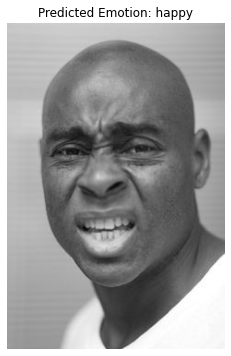

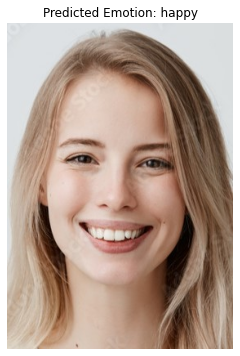

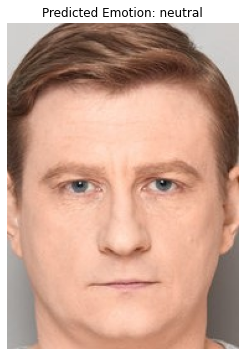

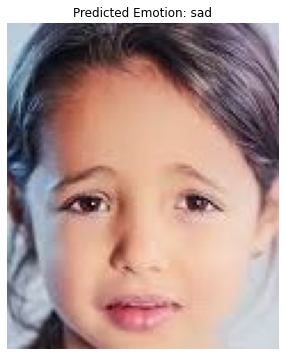

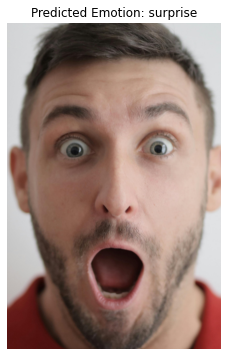

In [49]:
image_path = '/kaggle/input/face-images-for-prediction/disgustface.jpg'
predict_emotion(image_path)

image_path = '/kaggle/input/face-images-for-prediction/happyface.jpg'
predict_emotion(image_path)
image_path = '/kaggle/input/face-images-for-prediction/neutralface.jpg'
predict_emotion(image_path)
image_path = '/kaggle/input/face-images-for-prediction/sadface.jpg'
predict_emotion(image_path)
image_path = '/kaggle/input/face-images-for-prediction/surpriseface.jpg'
predict_emotion(image_path)



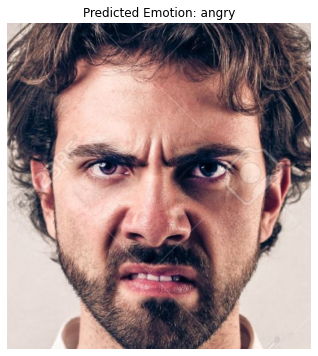

In [52]:
image_path = '/kaggle/input/face-images-for-prediction/angryface1.jpg'
predict_emotion(image_path)

